# "Hello Beam": A Uniform Rectangular Cantilevered Beam 

This tutorial introduces the major components of running a beam analysis and post processing using ALBATROSS.

This script demonstrates:
* Simple geometry construction
* Cross-sectional analysis
* 1D analysis

This tutorial may feel a bit longer than a simple "hello world" print statement that motivates the name, but it is important to remember that a beam analysis has a lot more going on than a few simple characters. This tutorial chooses to start with the simplest example possible involving a complete beam analysis, motivating the various subprocesses of geometry (re)construction, cross-sectional analysis, 1D analysis, and 3D recovery. The motivation here is to provide the user with some insight into the power of modeling slender structures as beams. 
<!-- 
The FEniCSx tutorial covers the [simulation of a cantilever beam](https://jsdokken.com/dolfinx-tutorial/chapter2/linearelasticity_code.html) subject to self-weight using a 3D formulation as shown in the figure. The benefit of a beam model is a massive reduction in the required degrees of freedom to acheive a *higher fidelity* solution as compared to the solid solution below:

![figure](../docs/src/images/FEniCSx_cantilever_beam.png) -->

We follow the convention that $x_1$ represents the direction along the beam axis and $x_2$ and $x_3$ represent the coordinates of the cross sections in the cross-sectional plane. The spatial coordinates of in which the beam axis and the cross-sections are defined and defrom are identified as $x$, $y$, and $z$. Note that the beam axis is a topologically 1D object embedded in geometrically 3D space. Each cross-section is a topologically 2D object embedded in geometrically 3D space.

We begin with our import statements and some general model parameters:



In [8]:
import numpy as np

import ALBATROSS

## Creating our beam cross-section geometry
While it is possible to analyze beams with non-uniform cross-sections, we will first cover the uniform straight beam case. Since the cross-section doesn't change along the beam we can run a *single* cross-section analysis for the entire beam.

In [9]:
#geometric parameters
N = 10 #number of quad elements per side on xc mesh
W = .1 #xs width
H = .1 #xs height
A = W*H #xs area

#create cross-sectional mesh of a rectangle with the origin at the center
# of the rectangle using the bottom left and upper right points
points = [[-W/2,-H/2],[W/2, H/2]]
squareXSmesh = ALBATROSS.mesh.create_rectangle(points,[N,N])

Now that we have a mesh, we need to supply the material information. For an isotropic, homogeneous beam, we have a single set of material parameters that are the same throughout the mesh. We construct a material object which we pass to the cross-section object when we initialize it.

In [10]:
#initialize a material object
unobtainium = ALBATROSS.material.Material(name='unobtainium',
                                           mat_type='ISOTROPIC',
                                           mech_props={'E':10e6,'nu':0.2},
                                           density=2700)

Now that we have a cross-sectional mesh and a material defined, let's initialize a cross-section object and run cross-sectional analysis


In [11]:
#initialize and run cross-sectional analysis
squareXS = ALBATROSS.cross_section.CrossSection(squareXSmesh,[unobtainium])
squareXS.get_xs_stiffness_matrix()

Constructing Residual...
Computing non-trivial solutions....
Assembling System Matrix....
Computing QR factorization
(1452, 1452)
QR factorization time = 0.060600
Orthogonalizing w.r.t. elastic modes...
Computing Beam Constitutive Matrix....


We now have a completed 2D analysis for our uniform rectangular cross-section.

We only have one cross-section, so let's initialize a list of all the cross-sections we will use to refer to this cross-section.

In [12]:
xs_list = [squareXS]

Let's plot the cross-section mesh now that we have the cross-section object initialized:


No module named 'trame'

Falling back to a static output.
  warnings.warn(



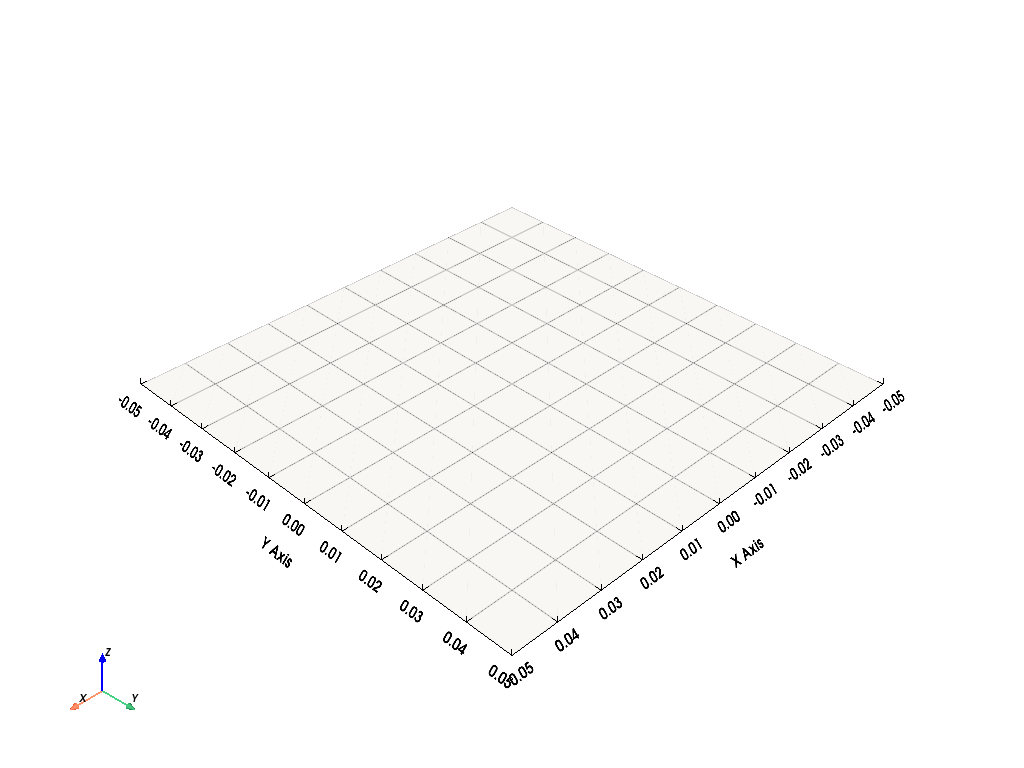

In [13]:
#show me what you got
squareXS.plot_mesh()

## Constructing a beam axis
A beam axis object is constructed in ALBATROSS by providing "segments" and the number of subdivision of those segments. For this simple case, we can simply provide one segment and subdivide this into 100 mesh elements for the 1D analysis. 

Cases in which one might want to provide multiple segments include:
* non-uniform or variable cross-sections along the beam axis
* kinked, swepted, or generally non-straight beam axes

At the present moment, only straight segments are supported. Note that this does not mean only straight beams are supported!

In order to construct the beam axis, we provide the start and end points of each segment, as well as the name of the mesh that will be constructed.

In [14]:
#length of beam:
L = 20 

#name of the mesh
meshname = 'tutorial_1'   

#beam axis endpoint locations
p1 = (0,0,0)
p2 = (L,0,0)

#collect start and end points to define the segment 
nodal_points = [p1,p2]

# number of segments (we'll use this later)
num_segments = len(nodal_points)-1 

#number of subdivisions for each beam segment
num_ele = [100]

#create the beam axis
beam_axis = ALBATROSS.axial.BeamAxis(nodal_points,num_ele,meshname)

Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Done meshing 1D (Wall 0.000262326s, CPU 0.000345s)
Info    : Meshing 2D...
Info    : Done meshing 2D (Wall 1.2722e-05s, CPU 1.4e-05s)
Info    : Meshing 3D...
Info    : Done meshing 3D (Wall 0.000316428s, CPU 0.000135s)
Info    : 2 nodes 3 elements
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Done meshing 1D (Wall 7.3927e-05s, CPU 0.00113s)
Info    : Meshing 2D...
Info    : Done meshing 2D (Wall 4.50799e-06s, CPU 6.6e-05s)
Info    : Meshing 3D...
Info    : Done meshing 3D (Wall 9.288e-06s, CPU 0.000131s)
Info    : 101 nodes 102 elements


## Initializing the Beam:
Now that we have a cross-section and a beam axis, we need to provide a little bit of information on how these object are related to each other in 3D space. 

The first piece of information is which cross-section is used in which segment. Since our beam only has one segment and we have the same cross-section utilized throughout the cross-section, provide the connectivity of the cross-sections to the beam segments. This is simply an "adjaceny list" identifying which cross-section id (e.g. index of the xs_list that we initialized previously) is used for each segment end point. 

The second piece of information is how the cross-sections are oriented in space. ALBATROSS chooses to provide a vector defining the orientation of the $x_2$ axis in ($x$,$y$,$z$) space at each segment node. Using the beam axis itself, ALBATROSS automatically determines the orientation of the $x_3$ axis.

Finally, we collect all of these items into a list we call "xs_info". We pass this list and the beam axis into the constructor of a Beam object.

In [15]:
 #define the connectivity for a uniform beam
xs_adjacency_list = [[0,0]]

#define orientation of each xs with a vector
orientations = np.tile([0,1,0],num_segments)

#collect all xs information
xs_info = [xs_list,orientations,xs_adjacency_list]

#initialize beam object using beam axis and definition of xs's
CantileverBeam = ALBATROSS.beam.Beam(beam_axis,xs_info)

Orienting XSs along beam axis....
Linking cross-sectional properties to axial mesh...
Done interpolating cross-sectional properties to axial mesh...
Initializing Axial Model (1D Analysis)
Computing Elastic Energy...


Now that we have a beam initialized, we need to apply boundary conditions and loads. For a cantilevered beam, we will specifiy a fixed point at $p_1$ and define a downward load at $p_2$. Then, we are read to solve the problem

In [16]:
#applied fixed bc to first endpoint
CantileverBeam.add_clamped_point(p1)

#define tip load magnitude 
F = .01 

#apply force at free end in the negative z direction
CantileverBeam.add_point_load([(0,0,-F)],[p2])

#solve the linear problem
CantileverBeam.solve()

Adding clamped point...
Adding point loads....
Solving for beam axis displacement...


## Post-processing and Visualization
Now that we have computed the 1D analysis displacement, we are ready to perfrom some post processing. First, lets visualize the 1D displacement (warped by a factor of 10 to make the displacement more clear)


No module named 'trame'

Falling back to a static output.
  warnings.warn(



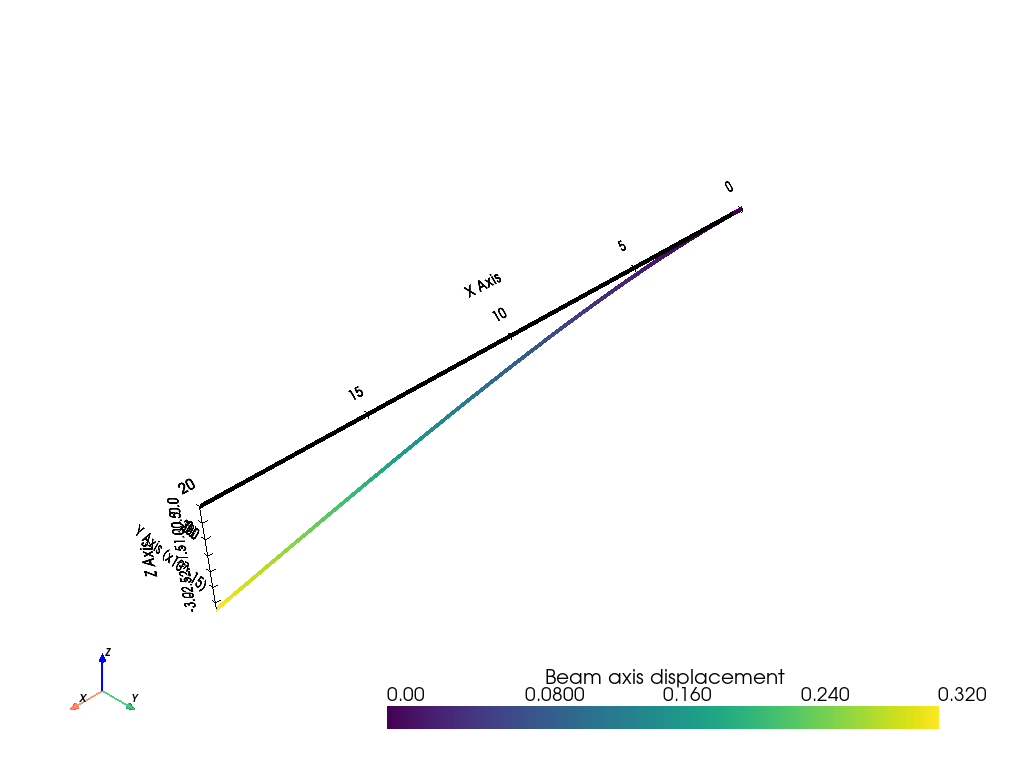

In [17]:
#shows plot of 1D displacement solution
CantileverBeam.plot_axial_displacement(warp_factor=10)

Now, we are ready to recover the full dispalcement of using the cross-section. We'll run displace recovery, then stress recovery and finish by plotting the displaced solution with the von-mises stress plotted over the cross-sectional elements.

In [18]:
#recovers the 3D displacement field over each xs
CantileverBeam.recover_displacement()

#shows plot of stress over cross-section 
CantileverBeam.recover_stress() 

#plots both 1D and 2D solutions together
CantileverBeam.plot_xs_disp_3D()

AttributeError: 'CrossSection' object has no attribute 'K1_inv'

## Validation against a known solution:
Since this is such a simple geometry, we actually have an analytical solution for the cross-sectional properties, displacements, and stresses in the beam. We can compare our com

### Axial Stiffness (EA):

In [ ]:
print("Analytical value:")
A = W*H
E=unobtainium.E #get material modulus of elasticity
print(E*A)
print("ALBATROSS computed value:")
print(squareXS.K[0,0])

### Analytical Bending stiffness (EI):


In [ ]:
print("Analytical value:")
I = (W*H**3)/12
print(E*I)
print("ALBATROSS computed value:")
print(squareXS.K[4,4])

### Max Tip Deflection for point load:

In [ ]:
print('EB analytical solution:')
print( (-F*L**3)/(3*E*I) )
print('ALBATROSS computed value:')
print(CantileverBeam.get_local_disp([p2])[0][2])

### Maximum Stress for point load (at root of beam)

In [ ]:
print('EB analytical solution:')
M = -F*L #maximum moment
print( (-H/2)* (-F*L) / I  )
print('ALBTROSS computed value:')
print( CantileverBeam.get_max_stress() )
